## Setup for data loading

In [1]:
import cv2
import h5py
from tqdm import tqdm   # ref: https://github.com/tqdm/tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F  # useful stateless functions

import matplotlib
from matplotlib.pyplot import plot, xlabel, ylabel, title, imshow
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import random
import copy

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

using device: cuda


## Load human detection training / test data

In [3]:
# Load human detection training data.
# Each human sample is stored as lists of
# bbox[iClip][iFrame] = narray(N,D)
# where N = number of people in the frame, and 
# D = 4 (x, y, width, height)
hf = h5py.File('truth_data/ground_truth_data_train.mat', 'r')
data = hf.get('ground_truth_data')['list']
bbox = {}
for d in data[0]:
    imgname = ''.join([chr(x) for x in hf[d]['imgname'][:]])
    iClip = imgname[4:7]
    iFrame = imgname[8:12]
    if iClip not in bbox:
        bbox[iClip] = {}
    bbox[iClip][iFrame] = np.int_(hf[d]['bbox'][:].T/6)
hf.close()

In [4]:
# Check number of human dectection samples.
nData = 0
for iClip in bbox:
    for iFrame in bbox[iClip]:
        nData += bbox[iClip][iFrame].shape[0]
nData

1607

In [5]:
# Load human detection test data.
hf = h5py.File('truth_data/ground_truth_data_test.mat', 'r')
data = hf.get('ground_truth_data')['list']
bbox_test = {}
for d in data[0]:
    imgname = ''.join([chr(x) for x in hf[d]['imgname'][:]])
    iClip = imgname[4:7]
    iFrame = imgname[8:12]
    if iClip not in bbox_test:
        bbox_test[iClip] = {}
    bbox_test[iClip][iFrame] = np.int_(hf[d]['bbox'][:].T/6)
hf.close()

In [6]:
nData_test = 0
for iClip in bbox_test:
    for iFrame in bbox_test[iClip]:
        nData_test += bbox_test[iClip][iFrame].shape[0]
nData_test

483

## Load video data

In [7]:
# Save corresponding clips (takes ~300s) / Training data
frame_buffer_n = 7   # how many frames for 3d conv (- n)
frame_every = 3
path = 'videos/'
frames = {}
for iClip in tqdm(bbox):
    videofile = path+'mv2_'+iClip+'.avi'
    cap = cv2.VideoCapture(videofile)
    frames[iClip] = {}
    for iFrame in bbox[iClip]:
        frame_buffer = []
        for iBuffer in range(-(frame_buffer_n-1)*frame_every, 1, frame_every):
        #for iBuffer in range(-frame_buffer_n, frame_buffer_n+1):
            cap.set(1, int(iFrame)+iBuffer)
            ret, frame = cap.read()
            if ret:
                frame_buffer.append(frame)
        frames[iClip][iFrame] = torch.from_numpy(np.stack(frame_buffer))

100%|██████████| 10/10 [05:00<00:00, 30.06s/it]


In [8]:
# print index of frames
for x in range(-(frame_buffer_n-1)*frame_every, 1, frame_every):
    print(x)

-18
-15
-12
-9
-6
-3
0


In [9]:
# Save corresponding clips (takes ~300s) / Test data
frames_test = {}
for iClip in tqdm(bbox_test):
    videofile = path+'mv2_'+iClip+'.avi'
    cap = cv2.VideoCapture(videofile)
    frames_test[iClip] = {}
    for iFrame in bbox_test[iClip]:
        frame_buffer = []
        for iBuffer in range(-(frame_buffer_n-1)*frame_every, 1, frame_every):
            cap.set(1, int(iFrame)+iBuffer)
            ret, frame = cap.read()
            if ret:
                frame_buffer.append(frame)
        frames_test[iClip][iFrame] = torch.from_numpy(np.stack(frame_buffer))

100%|██████████| 10/10 [01:12<00:00,  7.29s/it]


21 10


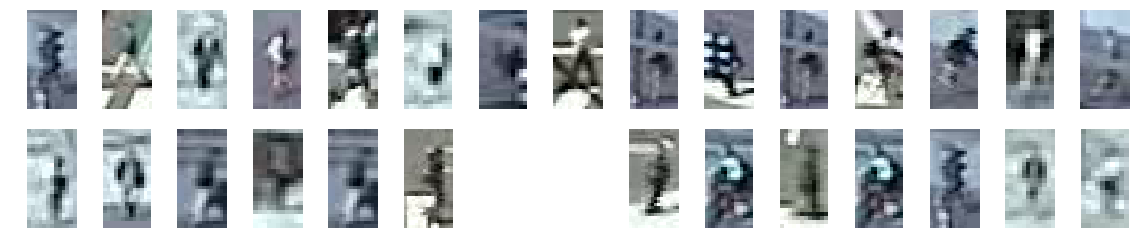

In [10]:
# Random sanity check
fig = plt.figure(figsize=(20,4))
for i in range(30):
    ax = fig.add_subplot(2,15,i+1)
    ax.axis('off')
    iClip = random.choice(list(bbox.keys()))
    iFrame = random.choice(list(bbox[iClip].keys()))
    try:
        x,y,w,h = bbox[iClip][iFrame][0]
        ax.imshow(frames[iClip][iFrame][6, y:y+h, x:x+w, :]) # when the pedestrian is at center (here, last)
    except:
        continue
print(h, w)

## Generate map from ground truth

100%|██████████| 10/10 [00:00<00:00, 110.23it/s]


(-0.5, 719.5, 479.5, -0.5)

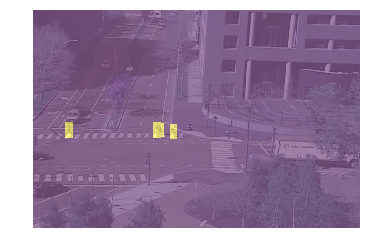

In [11]:
# Training
_, h, w, _ = frames['001']['0001'].shape
pedes_map = {}
for iClip in tqdm(bbox):
    pedes_map[iClip] = {}
    for iFrame in bbox[iClip]:
        tmp = np.zeros((h, w))
        for p in bbox[iClip][iFrame]:
            try:
                x, y, dx, dy = p
                tmp[y:y+dy, x:x+dx] = 1
            except:
                continue
        pedes_map[iClip][iFrame] = tmp
plt.imshow(frames[iClip][iFrame][-1, :, :], alpha=0.5)
plt.imshow(pedes_map[iClip][iFrame], alpha=0.5)
plt.axis('off')

100%|██████████| 10/10 [00:00<00:00, 310.30it/s]


(-0.5, 719.5, 479.5, -0.5)

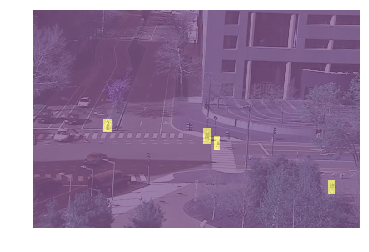

In [12]:
# Test
_, h, w, _ = frames['001']['0001'].shape
pedes_map_test = {}
for iClip in tqdm(bbox_test):
    pedes_map_test[iClip] = {}
    for iFrame in bbox_test[iClip]:
        tmp = np.zeros((h, w))
        for p in bbox_test[iClip][iFrame]:
            try:
                x, y, dx, dy = p
                tmp[y:y+dy, x:x+dx] = 1
            except:
                continue
        pedes_map_test[iClip][iFrame] = tmp
        
plt.imshow(frames_test[iClip][iFrame][-1, :, :], alpha=0.5)
plt.imshow(pedes_map_test[iClip][iFrame], alpha=0.5)
plt.axis('off')

## Training data - (3d; stack of) images
First, we will try training the data with still images of a person. Since the images of a person in the training data are not equal, we try 

1) crop/zero-padding the image to equal size, or 

2) scale the image.

100%|██████████| 10/10 [00:00<00:00, 42.49it/s]


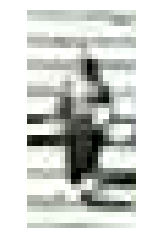

In [14]:
# Generating train data. All images are cropped to (40, 20).
# True data
h_0 = 40
w_0 = 20
X_sample = torch.zeros(nData,3,frame_buffer_n,h_0,w_0)
y_sample = torch.zeros(nData, )
i = 0
for iClip in tqdm(bbox):
    for iFrame in bbox[iClip]:
        for d in bbox[iClip][iFrame]:
            try:
                x, y, w, h = d
                x += int(w/2)
                y += int(h/2)
                if i == 100:
                    plt.imshow(frames[iClip][iFrame][-1, y-int(h_0/2):y+int(h_0/2), x-int(w_0/2):x+int(w_0/2),:])
                    plt.axis('off')
                data = frames[iClip][iFrame][:, y-int(h_0/2):y+int(h_0/2), 
                                             x-int(w_0/2):x+int(w_0/2), :].to(dtype=torch.float32)
                X_sample[i,:,:,:,:] = torch.unsqueeze(data.permute(3,0,1,2), 0)
                y_sample[i] = 1
                i += 1
            except:
                continue
X_sample = X_sample[:i,]
y_sample = y_sample[:i,]

In [15]:
X_sample.shape, y_sample.shape

(torch.Size([1568, 3, 7, 40, 20]), torch.Size([1568]))

In [16]:
# False data are randomly sampled from images.
# thres_sample: this index decide whether to include or not when randomly sampled image partically include pedestrian
thres_sample = 0.1
n = X_sample.shape[0]
false_num = 0
#for i in tqdm(range(4 * n)):
while false_num < (4 * n):
    iClip = random.choice(list(bbox.keys()))
    iFrame = random.choice(list(bbox[iClip].keys()))
    x = int(random.random()*705)
    y = int(random.random()*450)
    if (np.sum(pedes_map[iClip][iFrame][y:y+h_0, x:x+w_0])/(h_0 * w_0)) < thres_sample:
        try:
            if i == 100:
                plt.imshow(frames[iClip][iFrame][-1, y:y+h_0, x:x+w_0, :])
                plt.axis('off')
            data = frames[iClip][iFrame][:, y:y+h_0, x:x+w_0, :].to(dtype=torch.float32)
            X_sample = torch.cat((X_sample, torch.unsqueeze(data.permute(3,0,1,2),0)),0)
            y_sample = torch.cat((y_sample, torch.zeros(1)))
            false_num += 1
        except:
            continue
print(false_num)

6272


## Test data - 3d

100%|██████████| 10/10 [00:00<00:00, 108.25it/s]


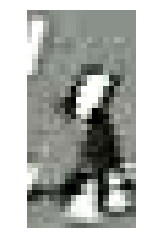

In [17]:
# Generating test data. All images are cropped to (40, 20).
# True data
h_0 = 40
w_0 = 20
X_sample_test = torch.zeros(nData_test,3,frame_buffer_n,h_0,w_0)
y_sample_test = torch.zeros(nData_test, )
i = 0
for iClip in tqdm(bbox_test):
    for iFrame in bbox_test[iClip]:
        for d in bbox_test[iClip][iFrame]:
            try:
                x, y, w, h = d
                x += int(w/2)
                y += int(h/2)
                #x -= int((w-w_0)/2)
                #y -= int((h-h_0)/2)
                if i == 130:
                    plt.imshow(frames_test[iClip][iFrame][-1, y-int(h_0/2):y+int(h_0/2), x-int(w_0/2):x+int(w_0/2),:])
                    plt.axis('off')
                data = frames_test[iClip][iFrame][:, y-int(h_0/2):y+int(h_0/2), 
                                                  x-int(w_0/2):x+int(w_0/2), :].to(dtype=torch.float32)
                X_sample_test[i,:,:,:,:] = torch.unsqueeze(data.permute(3,0,1,2), 0)
                y_sample_test[i] = 1
                i += 1
            except:
                continue
X_sample_test = X_sample_test[:i,]
y_sample_test = y_sample_test[:i,]

In [18]:
# False data are randomly sampled from images.
# thres_sample: this index decide whether to include or not when randomly sampled image partically include pedestrian
thres_sample = 0.1
n = X_sample_test.shape[0]
false_num = 0
#for i in tqdm(range(1 * n)):
while false_num < n:
    iClip = random.choice(list(bbox_test.keys()))
    iFrame = random.choice(list(bbox_test[iClip].keys()))
    x = int(random.random()*705)
    y = int(random.random()*450)
    if (np.sum(pedes_map_test[iClip][iFrame][y:y+h_0, x:x+w_0])/(h_0 * w_0)) < thres_sample:
        try:
            if i == 100:
                plt.imshow(frames_test[iClip][iFrame][-1, y:y+h_0, x:x+w_0, :])
                plt.axis('off')
            data = frames_test[iClip][iFrame][:, y:y+h_0, x:x+w_0, :].to(dtype=torch.float32)
            X_sample_test = torch.cat((X_sample_test, torch.unsqueeze(data.permute(3,0,1,2),0)),0)
            y_sample_test = torch.cat((y_sample_test, torch.zeros(1)))
            false_num += 1
        except:
            continue
print(false_num)

481


## Divide train and validation set

In [19]:
N = X_sample.shape[0]
N_train = int(N*.8)
mask = list(range(N))
random.shuffle(mask)
X_train = X_sample[mask[:N_train],]
X_val = X_sample[mask[N_train:],]
y_train = y_sample[mask[:N_train],]
y_val = y_sample[mask[N_train:],]

X_test = X_sample_test
y_test = y_sample_test

In [20]:
X_sample.shape, X_train.shape , X_test.shape

(torch.Size([7840, 3, 7, 40, 20]),
 torch.Size([6272, 3, 7, 40, 20]),
 torch.Size([962, 3, 7, 40, 20]))

## Sanity check

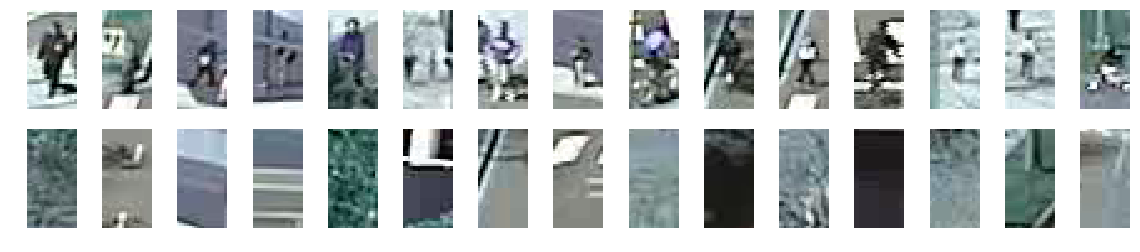

In [21]:
fig = plt.figure(figsize=(20,4))
for i in range(15):
    ax = fig.add_subplot(2,15,i+1)
    ax.axis('off')
    n = int(random.random()*1300)
    ax.imshow(X_sample[n][:, -1, :, :].permute(1,2,0).to(dtype=torch.uint8))

for i in range(15):
    ax = fig.add_subplot(2,15,i+16)
    ax.axis('off')
    n = int(random.random()*800)+1600
    ax.imshow(X_sample[n][:, -1, :, :].permute(1,2,0).to(dtype=torch.uint8))

## Functions for accuracy check and model training

In [22]:
def check_accuracy(X, y, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        N = X.shape[0]
        for i in range(N):
            xi = X[i].unsqueeze(0).to(device=device, dtype=dtype)  # move to device, e.g. GPU
            yi = y[i].unsqueeze(0).to(device=device, dtype=torch.long)
            scores = model(xi)
            _, preds = scores.max(1)
            #print(preds)
            num_correct += (preds == yi).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

        
def train_model(X, y, model, optimizer, epochs=1):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    N = X.shape[0]
    t = 0
    for e in tqdm(range(epochs)):
        for i in range(int(N/epochs)):
            Xt = X[t].unsqueeze(0).to(device=device, dtype=dtype)  # move to device, e.g. GPU
            yt = y[t].unsqueeze(0).to(device=device, dtype=torch.long)
            
            scores = model(Xt)
            loss = F.cross_entropy(scores, yt)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
        
            t += 1
            if t % 1000 == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(X_train, y_train, model)
                check_accuracy(X_val, y_val, model)
                print()

In [23]:
# Train CNN
#model = nn.Sequential(
#    nn.Conv3d(3, 32, 3, padding=1, stride=1),
#    nn.BatchNorm3d(32),
#    nn.MaxPool3d((1, 2, 2)),
#    nn.Conv3d(32, 32, 3, padding=1, stride=1),
#    nn.BatchNorm3d(32),
#    nn.MaxPool3d((1, 2, 2)),
#    nn.Conv3d(32, 16, 3, padding=1, stride=1),
#    nn.LeakyReLU(),
#    Flatten(),
#    nn.Linear(16*7*h_0/4*w_0/4, 30),
#    nn.LeakyReLU(),
#    nn.Linear(30, 2),
#)
#optimizer = optim.Adam(model.parameters(), lr=4e-5, betas=(0.9, 0.999))
#train_model(X_train, y_train, model, optimizer, epochs=10)

### ~ 93.57 % accuracy when N(true):N(false)=1:1

## Train the model with training dataset

In [90]:
# Train 3D-CNN
model = nn.Sequential(
    nn.Conv3d(3, 32, 3, padding=1, stride=1),
    #nn.BatchNorm3d(32),
    nn.MaxPool3d((1, 2, 2)),
    nn.Conv3d(32, 32, 3, padding=1, stride=1),
    #nn.BatchNorm3d(32),
    nn.MaxPool3d((1, 4, 2)),
    nn.Conv3d(32, 16, 3, padding=1, stride=1),
    nn.LeakyReLU(),
    Flatten(),
    nn.Linear(16*7*h_0/8*w_0/4, 30),
    nn.LeakyReLU(),
    nn.Linear(30, 2),
)
optimizer = optim.Adam(model.parameters(), lr=4e-5, betas=(0.9, 0.999))
train_model(X_train, y_train, model, optimizer, epochs=10)

 10%|█         | 1/10 [00:02<00:23,  2.58s/it]

Iteration 1000, loss = 0.1811
Got 5764 / 6272 correct (91.90)
Got 1413 / 1568 correct (90.11)



 30%|███       | 3/10 [00:16<00:38,  5.43s/it]

Iteration 2000, loss = 0.0253
Got 5915 / 6272 correct (94.31)
Got 1453 / 1568 correct (92.67)



 40%|████      | 4/10 [00:27<00:41,  6.87s/it]

Iteration 3000, loss = 0.0245
Got 6023 / 6272 correct (96.03)
Got 1488 / 1568 correct (94.90)



 60%|██████    | 6/10 [00:41<00:27,  6.85s/it]

Iteration 4000, loss = 0.0053
Got 6101 / 6272 correct (97.27)
Got 1507 / 1568 correct (96.11)



 70%|███████   | 7/10 [00:52<00:22,  7.48s/it]

Iteration 5000, loss = 0.0000
Got 5740 / 6272 correct (91.52)


 80%|████████  | 8/10 [01:03<00:15,  7.94s/it]

Got 1433 / 1568 correct (91.39)



 90%|█████████ | 9/10 [01:05<00:07,  7.33s/it]

Iteration 6000, loss = 0.1374
Got 6075 / 6272 correct (96.86)
Got 1492 / 1568 correct (95.15)



100%|██████████| 10/10 [01:17<00:00,  7.72s/it]


In [91]:
filters = []
for param in model.parameters():
    filters.append(torch.from_numpy(param.cpu().detach().numpy()).to(dtype=torch.float32))
for f in range(len(filters)):
    print(filters[f].shape)
print(len(filters))

torch.Size([32, 3, 3, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3, 3])
torch.Size([32])
torch.Size([16, 32, 3, 3, 3])
torch.Size([16])
torch.Size([30, 2800])
torch.Size([30])
torch.Size([2, 30])
torch.Size([2])
10


## Predict the probability of location of pedestrian with our 3d-CNN model
## in the whole image

In [212]:
#_, H, W, _ = frames['001']['0001'].shape
#zzzzzzz = torch.zeros((2, H, W))
#frame_pading = F.pad(frames['001']['0001'].permute(3, 0, 1, 2), (10, 9, 20, 19, 0, 0), 'constant', 0)
#zzzzz = model(frame_pading[:, :, :40, :20].unsqueeze(0).to(device=device, dtype=dtype))
#for h in tqdm(np.arange(0, H, 20)):
#    for w in range(0, W, 10):
#        zzzzzzz[0, h, w] = model(frame_pading[:, :, :40, :20].unsqueeze(0).to(device=device, dtype=dtype))[0, 0]
#        zzzzzzz[1, h, w] = model(frame_pading[:, :, :40, :20].unsqueeze(0).to(device=device, dtype=dtype))[0, 1]
#for h in range(H):
#    for w in range(W):
#imshow(frame['001']['0001'][-1, :40, :20, :])
#zzz = model(frames['001']['0001'].permute(3, 0, 1, 2).view(1, ))

  0%|          | 0/24 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1524590031827/work/aten/src/THC/generic/THCStorage.cu:58

In [222]:
def predict_ped(inputs, filters):
    z = F.conv3d(inputs, filters[0], bias=filters[1], padding=1, stride=1)
    #z = F.batch_norm(z, filters[2], filters[3])
    z = F.max_pool3d(z, (1, 2, 2))
    z = F.conv3d(z, filters[2], bias=filters[3], padding=1, stride=1)
    #z = F.batch_norm(z, filters[6], filters[7])
    z = F.max_pool3d(z, (1, 4, 2))
    z = F.conv3d(z, filters[4], bias=filters[5], padding=1, stride=1)
    z = F.leaky_relu(z)
    tmp = torch.reshape(filters[6], (30, 16, 7, 5, 5))
    z = F.conv3d(z, tmp, bias=filters[7], padding=(0, 2, 2), stride=1)
    z = F.leaky_relu(z)
    z = torch.mm(filters[8], torch.reshape(z, (30, -1)))
    z = torch.reshape(z, (2, 60, 180))
    z = z[1, :, :] + filters[9][1] - z[0, :, :] + filters[9][0]
    return z

(-0.5, 179.5, 59.5, -0.5)

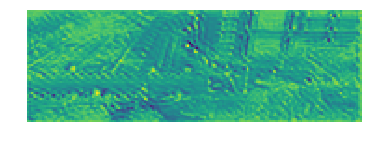

In [224]:
# Test w/ one example
inputs = torch.from_numpy(np.array(frames['001']['0201'].permute(3, 0, 1, 2).unsqueeze(0))).to(dtype=torch.float32)
z1 = predict_ped(inputs, filters)
plt.imshow(z1)
plt.axis('off', aspect='auto')


100%|██████████| 10/10 [17:28<00:00, 104.82s/it]


(-0.5, 179.5, 59.5, -0.5)

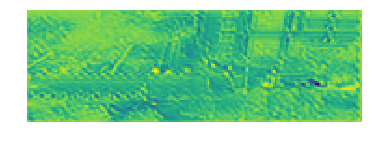

In [225]:
pedes_map_pred = {}
for iClip in tqdm(bbox):
    pedes_map_pred[iClip] = {}
    for iFrame in bbox[iClip]:
        inputs = torch.from_numpy(np.array(frames[iClip][iFrame].permute(3, 0, 1, 2).unsqueeze(0))).to(dtype=torch.float32)
        pedes_map_pred[iClip][iFrame] = predict_ped(inputs, filters)
plt.imshow(pedes_map_pred[iClip][iFrame])
plt.axis('off')

100%|██████████| 5/5 [00:00<00:00,  5.97it/s]


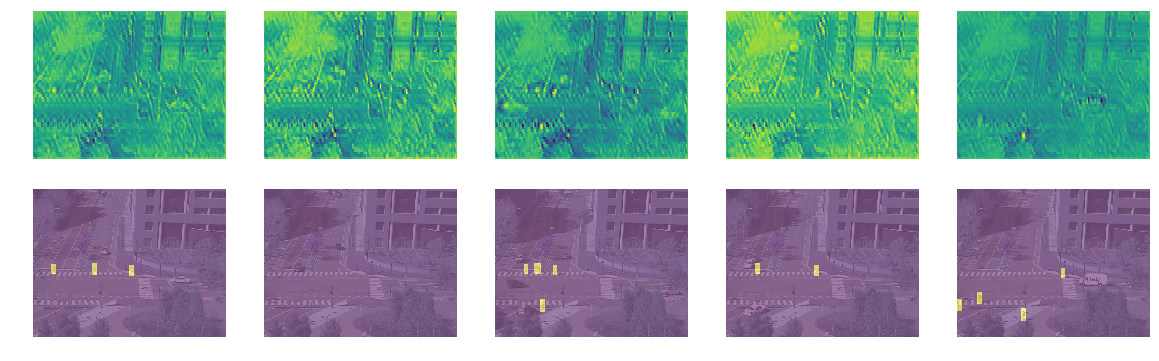

In [226]:
n = 5
fig = plt.figure(figsize=(20,6))
for i in tqdm(range(n)):
    iClip = random.choice(list(bbox.keys()))
    iFrame = random.choice(list(bbox[iClip].keys()))
    # Prediction by our 3D-CNN model
    ax = fig.add_subplot(2, n, i+1)
    ax.imshow(pedes_map_pred[iClip][iFrame], aspect='auto')
    ax.axis('off')
    # Compare with ground truth
    ax = fig.add_subplot(2, n, n+i+1)
    ax.imshow(frames[iClip][iFrame][-1, :, :], aspect='auto', alpha=0.5)
    ax.imshow(pedes_map[iClip][iFrame], aspect='auto', alpha=0.5)
    ax.axis('off')

## Quantify the prediction by model

### (1) Thresholded prediction & ground truth

100%|██████████| 5/5 [00:00<00:00,  8.56it/s]


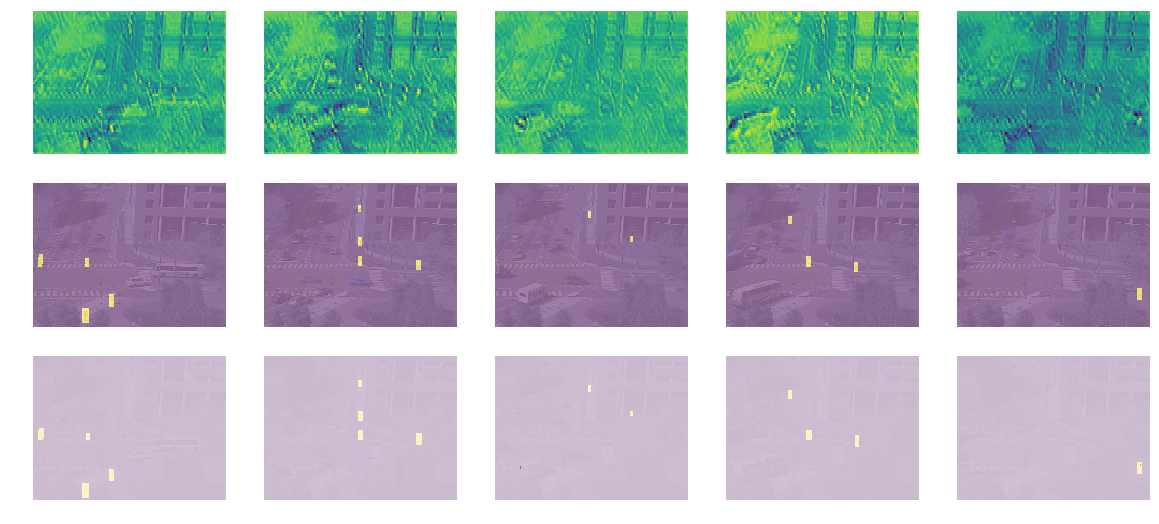

In [227]:
n = 5
fig = plt.figure(figsize=(20,9))
for i in tqdm(range(n)):
    iClip = random.choice(list(bbox.keys()))
    iFrame = random.choice(list(bbox[iClip].keys()))
    
    # Prediction by our 3D-CNN model
    ax = fig.add_subplot(3, n, i+1)
    ax.imshow(pedes_map_pred[iClip][iFrame], aspect='auto')
    ax.axis('off')
    
    # Compare with ground truth
    ax = fig.add_subplot(3, n, n+i+1)
    ax.imshow(frames[iClip][iFrame][-1, :, :], aspect='auto', alpha=0.3)
    ax.imshow(pedes_map[iClip][iFrame], aspect='auto', alpha=0.5)
    ax.axis('off')
   
    # Draw on raw image
    thres = 6
    t = torch.Tensor([thres])  # threshold
    out = (pedes_map_pred[iClip][iFrame] > t).float() * 1
    ax = fig.add_subplot(3, n, 2*n+i+1)
    ax.imshow(frames[iClip][iFrame][-1, :, :][::8, ::4], aspect='auto', alpha=0.1)
    ax.imshow(pedes_map[iClip][iFrame][::8, ::4], vmin=0, vmax=1, aspect='auto', alpha=0.4)
    #ax.imshow(pedes_map_pred[iClip][iFrame], vmin=1, vmax=6, aspect='auto', alpha=0.5)
    ax.imshow(out, cmap='bwr', aspect='auto', vmin=-0.1, vmax=0.1, alpha=0.4)
    ax.axis('off') 

### (2) Region prob -> store max value

In [258]:
def calculate_region_score(pedes_map_pred, thres=7):
    #thres = 6.9   # thresholding for prediction map (discard below)
    thres2 = 1 # thresholding for region proposal (at least thres+1 pixels should be included in the box)
    h_0 = int(40 / 8)
    w_0 = int(20 / 4)
    h, w = pedes_map_pred['001']['0001'].shape        # shape(120, 180)
    pedes_map_pred_copy = copy.deepcopy(pedes_map_pred)
    region_pred_map = {}
    score_map = {}
    i = 0
    for iClip in bbox:
        region_pred_map[iClip] = {}
        score_map[iClip] = {}
        for iFrame in bbox[iClip]:
            score_map[iClip][iFrame] = np.zeros((4,))
            total_true_n = bbox[iClip][iFrame].shape[0]
            total_pred_n = 0
            total_fp = 0
            total_pos = 0
            max_remain = True
            tmp = np.zeros((h, w))
            max_find = pedes_map_pred_copy[iClip][iFrame].numpy()
            max_find_t = (max_find > thres) * 1        # thresholded
            while max_remain:
                max_idx = np.unravel_index(np.argmax(max_find, axis=None), max_find.shape)
                if max_find[max_idx] > thres:
                    if np.sum(max_find_t[int(max_idx[0]-h_0/2):int(max_idx[0]+h_0/2), 
                                         int(max_idx[1]-w_0/2):int(max_idx[1]+w_0/2)]) > thres2:
                        tmp[int(max_idx[0]-h_0/2):int(max_idx[0]+h_0/2), int(max_idx[1]-w_0/2):int(max_idx[1]+w_0/2)] = 1
                        max_find[int(max_idx[0]-h_0/2):int(max_idx[0]+h_0/2), int(max_idx[1]-w_0/2):int(max_idx[1]+w_0/2)] = -100
                        i += 1
                        total_pred_n += 1
                        if np.sum(pedes_map[iClip][iFrame][::8, ::4][int(max_idx[0]-h_0/2):int(max_idx[0]+h_0/2), 
                                                                     int(max_idx[1]-w_0/2):int(max_idx[1]+w_0/2)]) > 0.10*h_0*w_0:
                            total_pos += 1
                        else:
                            total_fp += 1
                    else:
                        max_find[int(max_idx[0]):int(max_idx[0]+1), int(max_idx[1]):int(max_idx[1]+1)] = -100
                else:
                    max_remain = False
            region_pred_map[iClip][iFrame] = tmp
            score_map[iClip][iFrame][0] = total_true_n
            score_map[iClip][iFrame][1] = total_pred_n
            score_map[iClip][iFrame][2] = total_fp
            score_map[iClip][iFrame][3] = total_pos
    return region_pred_map, score_map 

100%|██████████| 5/5 [00:03<00:00,  1.26it/s]


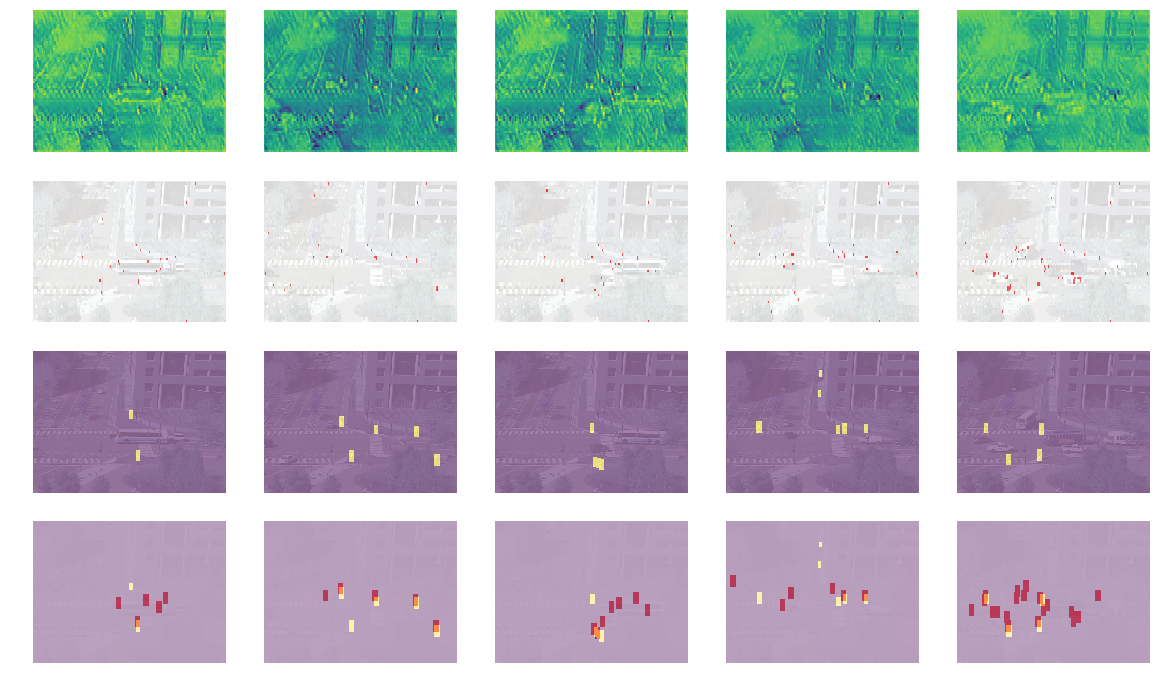

In [259]:
n = 5
fig = plt.figure(figsize=(20,12))
for i in tqdm(range(n)):
    iClip = random.choice(list(bbox.keys()))
    iFrame = random.choice(list(bbox[iClip].keys()))
    
    # Prediction by our 3D-CNN model
    ax = fig.add_subplot(4, n, i+1)
    ax.imshow(pedes_map_pred[iClip][iFrame], aspect='auto')
    ax.axis('off')
    
    # Draw on raw image after thresholding
    thres = 1
    t = torch.Tensor([thres])  # threshold
    out = (pedes_map_pred[iClip][iFrame] > t).float() * 1
    ax = fig.add_subplot(4, n, n+i+1)
    ax.imshow(frames[iClip][iFrame][-1, :, :][::8, ::4], aspect='auto', alpha=0.4)
    ax.imshow(out, cmap='bwr', aspect='auto', vmin=-0.1, vmax=0.1, alpha=0.6)
    ax.axis('off') 
    
    # Ground truth
    ax = fig.add_subplot(4, n, 2*n+i+1)
    ax.imshow(frames[iClip][iFrame][-1, :, :], aspect='auto', alpha=0.3)
    ax.imshow(pedes_map[iClip][iFrame], aspect='auto', alpha=0.5)
    ax.axis('off')
   
    # Compare w/ ground truth
    region_pred_map, _ = calculate_region_score(pedes_map_pred, thres)
    ax = fig.add_subplot(4, n, 3*n+i+1)
    ax.imshow(frames[iClip][iFrame][-1, :, :][::8, ::4], aspect='auto', alpha=0.1)
    ax.imshow(pedes_map[iClip][iFrame][::8, ::4], vmin=0, vmax=1, aspect='auto', alpha=0.6)
    ax.imshow(region_pred_map[iClip][iFrame], cmap='bwr', vmin=-1, vmax=1, aspect='auto', alpha=0.4)
    ax.axis('off') 

In [260]:
def calculate_scores(score_map):
    total_score = np.zeros((6,))
    for iClip in bbox:
        for iFrame in bbox[iClip]:
            total_score[0] += score_map[iClip][iFrame][0] # total truth
            total_score[1] += score_map[iClip][iFrame][1] # total prediction
            total_score[2] += score_map[iClip][iFrame][2] # false positive
            total_score[3] += score_map[iClip][iFrame][3] # positive
    total_score[4] = total_score[2] / 420                               # false-positive rate per image
    total_score[5] = (total_score[0] - total_score[3])/total_score[0]   # miss-rate
    return total_score
#print(total_score, total_score[3]/total_score[0], total_score[2])

In [261]:
thres_search = np.arange(-1, 14, 0.3)
print(thres_search)

[-1.  -0.7 -0.4 -0.1  0.2  0.5  0.8  1.1  1.4  1.7  2.   2.3  2.6  2.9
  3.2  3.5  3.8  4.1  4.4  4.7  5.   5.3  5.6  5.9  6.2  6.5  6.8  7.1
  7.4  7.7  8.   8.3  8.6  8.9  9.2  9.5  9.8 10.1 10.4 10.7 11.  11.3
 11.6 11.9 12.2 12.5 12.8 13.1 13.4 13.7]


In [262]:
score_thres = np.zeros((thres_search.shape[0], 6))
for i, t in tqdm(enumerate(thres_search)):
    _, score_map = calculate_region_score(pedes_map_pred, t)
    total_score = calculate_scores(score_map)
    score_thres[i, :] = total_score

50it [00:26,  1.88it/s]


[Text(0,0,'0.01'), Text(0,0,'0.1'), Text(0,0,'1.0'), Text(0,0,'10.0')]

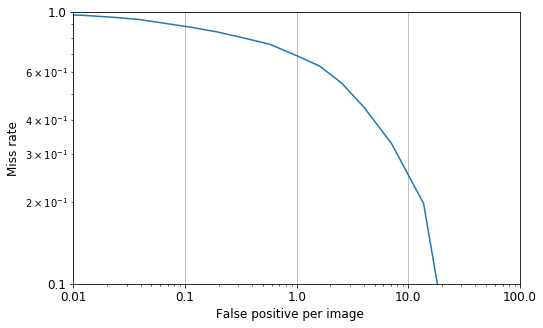

In [263]:
fig = plt.figure(figsize=(8,5))
fig.text(0.5, 0.03, 'False positive per image', ha='center', fontsize=12)
fig.text(0.01, 0.5, 'Miss rate', va='center', rotation='vertical', fontsize=12)
ax = fig.add_subplot(111)
ax.loglog(score_thres[:, 4], score_thres[:, 5])
ax.set_xlim(0.01, 100.)
ax.set_ylim(0.1, 1.0) 
ax.grid(True)
ax.set_xticklabels(ax.get_xticks(), fontsize=12)
ax.set_yticklabels(ax.get_yticks(), fontsize=12)